### Test the following classification with CIFAR100

1. Basic NN model with flattened image
2. Basic CNN model
    - different ConvNets: Transfer learning with ImageNet, InceptionNet, Resnet
    - use CDN labs for CNN, Pytorch tutorial that you used before
### Evaluation Metrics
Accuracy, f1 scores, mAP, ROC-AUC

### Basic NN model with Pytorch

In [102]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10 # provide standard datasets, transformations to convert images into tensors as well

from torchvision.transforms import ToTensor 
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader # create batches of data for batch gradient descent
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [6]:
# take jpg files and convert them into pytorch tensors
dataset = CIFAR10(root='data/', download=True, transform=ToTensor())

170499072it [00:21, 7956454.97it/s]                                


Extracting data/cifar-10-python.tar.gz to data/


In [7]:
img, label = dataset[0]
img.shape

torch.Size([3, 32, 32])

image.shape: torch.Size([3, 32, 32])
Label: 9


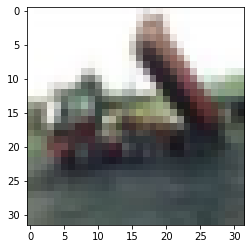

In [9]:
image, label = dataset[2]
print('image.shape:', image.shape)
plt.imshow(image.permute(1, 2, 0), cmap='gray')
print('Label:', label)

## Prepare data into training and validation set

Next, let's use the `random_split` helper function to set aside 10000 images for our validation set.

In [14]:
val_size = 10000
train_size = len(dataset) - val_size

batch_size=128
# make it as large as possible while it is still making the training faster
# matrix operations can still be slow -> start with 32, 64, and doubling it to make training faster 


# random_split because if you don't, the last 20% will only have 8 and 9s, causing the model to be unfair
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(40000, 10000)

## dataloaders
* create iterable dataloaders

In [15]:
train_loader = DataLoader(train_ds, 
                          batch_size, 
                          shuffle=True, 
                          num_workers=4, 
                          pin_memory=True)

# shuffle=True : training algo works better when you are randomising batches everytime, avoid biases
val_loader = DataLoader(val_ds, 
                        batch_size*2, 
                        num_workers=4, 
                        pin_memory=True)

# alternatively, use the indices method as stated in the video, but this is better

### Model
* create nn with 1 single layer

In [18]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    # flattened image
    inputs = images.reshape(-1, 3072)
    print('inputs.shape:', inputs.shape)
    break

images.shape: torch.Size([128, 3, 32, 32])
inputs.shape: torch.Size([128, 3072])


In [24]:
input_size = inputs.shape[-1]
hidden_size = 32

# create linear layer to test, naive linear layer
layer1 = nn.Linear(input_size, hidden_size)
# list(layer1.parameters())
print(layer1.weight.shape)
print(layer1.bias.shape)

torch.Size([32, 3072])
torch.Size([32])


In [36]:
for xb, yb in train_loader:
    print(xb.shape)
    # .view is same as reshape
    # make the size generic (as our images can be different shapes)
    # -1 => pytorch calculates it (you want 128*x, which x = 784)

    # flatten it!
    xb = xb.view(xb.size(0), -1) # xb.size(0) == 100 in this context
    print(xb.shape)
    break

torch.Size([128, 3, 32, 32])
torch.Size([128, 3072])


In [105]:
import torch.nn.functional as F
import torch.nn as nn

class ContamModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__() 
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

# define accuracy function
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [107]:
input_size = 3072
hidden_size = 128 # you can change this
num_classes = 10 # because its CIFAR10 with 10 classes

# init model object
model = ContamModel(input_size, hidden_size=hidden_size, out_size=num_classes)

In [108]:
model

ContamModel(
  (linear1): Linear(in_features=3072, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=10, bias=True)
)

In [103]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)
print('Softmax sample outputs :\n', F.softmax(outputs)[0])
print('Softmax sample summed :\n', torch.sum(F.softmax(outputs)[0]))

Loss: 2.3226799964904785
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.3021, -0.0936,  0.0379,  0.0334,  0.1431, -0.0168, -0.0165, -0.2107,
          0.0592,  0.1760],
        [ 0.2251, -0.0732, -0.0439,  0.0801,  0.1989, -0.0775,  0.0045, -0.1752,
         -0.0584,  0.2039]])
Softmax sample outputs :
 tensor([0.1286, 0.0866, 0.0987, 0.0983, 0.1097, 0.0935, 0.0935, 0.0770, 0.1009,
        0.1133], grad_fn=<SelectBackward0>)
Softmax sample summed :
 tensor(1.0000, grad_fn=<SumBackward0>)


/var/folders/33/lggb1gw96zb0tpc81z2n9yd40000gn/T/ipykernel_72464/235336798.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print('Softmax sample outputs :\n', F.softmax(outputs)[0])
/var/folders/33/lggb1gw96zb0tpc81z2n9yd40000gn/T/ipykernel_72464/235336798.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print('Softmax sample summed :\n', torch.sum(F.softmax(outputs)[0]))


In [53]:
print(torch.cuda.is_available())

# create a device
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()
device

# move data to device
# move data to device
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


# DeviceDataLoader to wrap existing loaders 
# move batch of data to selected device
# don't need to extend existing class to create 
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    # constructor
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    # for loop
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            # returning something, without stopping the program, "return" 
            yield to_device(b, self.device)

    # return number of batches
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

False


In [54]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [60]:
### model training
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

# load model onto GPU
# Model (on GPU)
model = ContamModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

# initial evaluation before training
history = [evaluate(model, val_loader)]


[{'val_loss': 2.307886838912964, 'val_acc': 0.09951172024011612}]

In [73]:
import time
start = time.process_time()
# your code here    
history += fit(10, 0.1, model, train_loader, val_loader)
print(time.process_time() - start)


Epoch [0], val_loss: 1.7514, val_acc: 0.3869
Epoch [1], val_loss: 1.5933, val_acc: 0.4478
Epoch [2], val_loss: 1.5773, val_acc: 0.4463
Epoch [3], val_loss: 1.5548, val_acc: 0.4592
Epoch [4], val_loss: 1.6645, val_acc: 0.4188
Epoch [5], val_loss: 1.6877, val_acc: 0.4201
Epoch [6], val_loss: 1.5488, val_acc: 0.4567
Epoch [7], val_loss: 1.6533, val_acc: 0.4282
Epoch [8], val_loss: 1.5392, val_acc: 0.4608
Epoch [9], val_loss: 1.6996, val_acc: 0.4057
305.28036800000007


###

In [77]:
# save model
torch.save(model.state_dict(), 'models_trained/cifar10-feedforward.pth')

### Predict

In [64]:
# Define test dataset
test_dataset = CIFAR10(root='data/', 
                     train=False,
                     transform=ToTensor())

In [65]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 3 , Predicted: 3


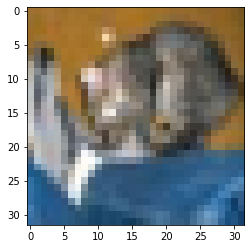

In [75]:
img, label = test_dataset[0]
# plt.imshow(img[0])
plt.imshow(img.permute(1, 2, 0), cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 1 , Predicted: 3


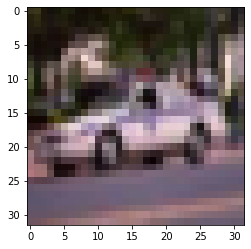

In [72]:
img, label = test_dataset[193]
# plt.imshow(img[0])
plt.imshow(img.permute(1, 2, 0), cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 1 , Predicted: 3


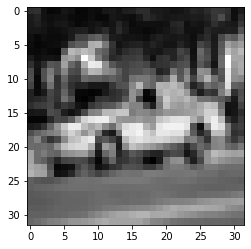

In [71]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

### f1 score

In [100]:

from sklearn.metrics import f1_score   
test_dataset = CIFAR10(root='data/', 
                     train=False,
                     transform=ToTensor())

y = test_dataset.targets
# y_targ = to_device(y, device)


Y_pred = model(test_dataset)
_, preds  = torch.max(Y_pred, dim=1)

f1_score = f1_score(y, preds)
# f1_score

AttributeError: 

In [110]:
from torchvision import models
from torchsummary import summary
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         393,344
            Linear-2                   [-1, 10]           1,290
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 1.51
Estimated Total Size (MB): 1.52
----------------------------------------------------------------
